In [32]:
import pandas as pd
import numpy as np

from matplotlib.rcsetup import validate_verbose
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import preprocessing
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split
df = pd.read_csv (r'/content/94matched_url_body_casetitles.csv',usecols = ['case_title_y'])
# df = df.sample(frac=1).reset_index(drop=True)
df.head()

,case_title_y
0,DBFS API 2.0
1,Databricks Runtime 10.4 LTS
2,Databricks Runtime 10.4 LTS
3,Databricks Runtime 10.4 LTS
4,Access Azure Data Lake Storage using Azure Act...


#PREPROCESSING AND NORMALIZATION

In [2]:
import re
import string 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.update(["nan"])

def heavy_text_clean(x):
    # first we lowercase everything
    x = x.lower()
    x = ' '.join([word for word in x.split(' ') if word not in stopwords])
    # remove unicode characters
    x = x.encode('ascii', 'ignore').decode()
    x = re.sub(r'https*\S+', ' ', x)
    x = re.sub(r'http*\S+', ' ', x)
    # then use regex to remove @ symbols and hashtags
    x = re.sub(r'@\S', '', x)
    x = re.sub(r'#\S+', ' ', x)
    x = re.sub(r'\'\w+', '', x)
    x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
    x = re.sub(r'\w*\d+\w*', '', x)
    x = re.sub(r'\s{2,}', ' ', x)
    x = re.sub(r'\s[^\w\s]\s', '', x)
    # remove single letters and numbers surrounded by space
    x = re.sub(r'\s[a-z]\s|\s[0-9]\s', ' ', x)
    return x

In [3]:
df['cleaned_text'] = df.case_title_y.apply(heavy_text_clean)

In [4]:
df.head()

,case_title_y,cleaned_text
0,DBFS API 2.0,dbfs api
1,Databricks Runtime 10.4 LTS,databricks runtime lts
2,Databricks Runtime 10.4 LTS,databricks runtime lts
3,Databricks Runtime 10.4 LTS,databricks runtime lts
4,Access Azure Data Lake Storage using Azure Act...,access azure data lake storage using azure act...


#TOKENIZING 

In [5]:
def tokenize(text):
    tokens=re.split('\W+',text)
    return tokens
df['intent_tokenized']=df['cleaned_text'].apply(lambda x:list(set(tokenize(x.lower()))))
df.head()

,case_title_y,cleaned_text,intent_tokenized
0,DBFS API 2.0,dbfs api,"[dbfs, , api]"
1,Databricks Runtime 10.4 LTS,databricks runtime lts,"[lts, databricks, runtime]"
2,Databricks Runtime 10.4 LTS,databricks runtime lts,"[lts, databricks, runtime]"
3,Databricks Runtime 10.4 LTS,databricks runtime lts,"[lts, databricks, runtime]"
4,Access Azure Data Lake Storage using Azure Act...,access azure data lake storage using azure act...,"[storage, lake, active, directory, azure, data..."


#USING .explode from Pandas library 

In [6]:
df1 = df.explode('intent_tokenized')

df1.head()

,case_title_y,cleaned_text,intent_tokenized
0,DBFS API 2.0,dbfs api,dbfs
0,DBFS API 2.0,dbfs api,
0,DBFS API 2.0,dbfs api,api
1,Databricks Runtime 10.4 LTS,databricks runtime lts,lts
1,Databricks Runtime 10.4 LTS,databricks runtime lts,databricks


#LENGTH of sentence 

In [7]:
%%capture
!pip install sentence-transformers

In [8]:
df1_Original= df1[df1['intent_tokenized'].apply(lambda x : len(x)<=10)]
df_Original = df1_Original.dropna()

In [9]:
corpus1 = df_Original['intent_tokenized'].to_list()

In [135]:
#FILTER THE NOUNS FOR THE WORDS

#THRESHOLD/PRUNNING WORDS

In [10]:
import nltk
nltk.download('averaged_perceptron_tagger')
from collections import Counter
c = Counter(corpus1)
top_1000_words = c.most_common()[:1000]

# list(map(lambda x:x[0] , top_1000_words))
# list(filter(lambda x:x if nltk.pos_tag([x[0]])[0][1] == "NN" and len(x) > 4  else False, top_1000_words))
final = list(filter(lambda x: nltk.pos_tag([x[0]])[0][1] =="NN" and len(x[0]) > 2, top_1000_words))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [11]:
final = [x[0] for x in final]


In [12]:
new_df = pd.DataFrame({
    "words" : final
})
new_df

,words
0,azure
1,configure
2,api
3,access
4,storage
...,...
96,context
97,github
98,version
99,batch


In [13]:
corpus = list(new_df["words"].to_list())

In [14]:

from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer('all-mpnet-base-v2')
import re
#import preprocessor as p 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [16]:
corpus_embeddings = embedder.encode(corpus)

In [25]:
corpus_embeddings.shape

(101, 768)

#DIMENSION REDUCTION

In [27]:
pca = PCA( 0.95, random_state=2140)
data_pca = pca.fit_transform(corpus_embeddings)

#Clustering with K-means
Selecting number of clusters

In [30]:
cluster_sizes = range(2, 20+1)
kmeans_models = [ KMeans(i, n_init=20, random_state=2140) for i in cluster_sizes ]
cluster_score = []

for kmeans in kmeans_models:
  y = kmeans.fit_predict(data_pca)
  score = silhouette_score(data_pca, y)
  cluster_score.append( ( kmeans.n_clusters, score) )

cluster_score=np.array(cluster_score)

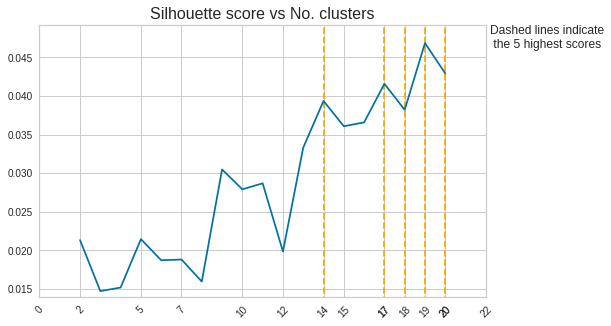

In [33]:
scores = cluster_score[:, 1]
clusters = cluster_score[:, 0]
max_score_clusters = []

fig, ax = plt.subplots( figsize=(8,5) )
ax = sns.lineplot( x=clusters, y=scores, ax=ax )
ax.set_title("Silhouette score vs No. clusters", fontsize=16)

for i in np.argsort( scores )[-5:]:
  ax.vlines(clusters[i], 0, 1, linestyles='--', colors='orange')
  max_score_clusters.append( clusters[i] )

ax.text(1.01, 1, f"Dashed lines indicate\n the {len(max_score_clusters)} highest scores",
        transform=ax.transAxes, ha='left', va='top')

xticks = ax.get_xticks().astype(int)
xticks = np.append(xticks, max_score_clusters)
ax.set_xticks( xticks )
ax.tick_params(axis='x', rotation=45)

ax.set_ylim( [ 0.95*min(scores), 1.05*max(scores) ] )
ax.set_xlim( [ 0, max(clusters)+2 ] )

plt.show()

In [54]:
num_clusters = 25
clustering_model =KMeans(n_clusters=num_clusters, n_init=20, random_state=2140)
clustering_model.fit(data_pca)

KMeans(n_clusters=25, n_init=20, random_state=2140)

In [55]:
cluster_assignment = clustering_model.labels_
cluster_df = pd.DataFrame(corpus,columns = ['corpus'])
cluster_df['cluster'] = cluster_assignment
cluster_df.sort_values('cluster')

,corpus,cluster
36,level,0
31,customer,0
72,account,0
75,name,0
73,domain,0
...,...,...
40,vnet,24
38,deploy,24
26,microsoft,24
19,unity,24


In [56]:
cluster_count = cluster_df.groupby('cluster').count()
cluster_count['corpus'].sort_values(ascending = False).head(50)
cluster_df.head()

,corpus,cluster
0,azure,24
1,configure,11
2,api,5
3,access,5
4,storage,22


In [57]:
count_df = cluster_df.groupby(['cluster']).size().reset_index(name='count')
count_dict =  count_df.set_index('cluster')['count'].to_dict()
cluster_df['Cluster_count'] = cluster_df['cluster'].apply(lambda x : count_dict[x])
cluster_df.head(50)

,corpus,cluster,Cluster_count
0,azure,24,5
1,configure,11,4
2,api,5,3
3,access,5,3
4,storage,22,4
5,directory,22,4
6,scim,12,7
7,apache,19,5
8,manage,4,3
9,configuration,11,4


In [58]:
cluster_df = cluster_df.sort_values('Cluster_count',ascending=False)
#df.sort_values(['a', 'b'], ascending=[False, False])
cluster_df

,corpus,cluster,Cluster_count
22,runtime,6,10
78,output,6,10
41,injection,6,10
96,context,6,10
95,execution,6,10
...,...,...,...
65,error,20,2
13,lake,13,2
29,dbfs,21,2
70,wasb,21,2


#Most Important words in each cluster

In [59]:
df = cluster_df

In [60]:
from collections import Counter
def common_word(df):
  cluster_name = {}
  # cluster_name_2 = {}

  for i in df['cluster']:
    data = df[df['cluster'] == i]
    word_list = data['corpus'].to_list()
    # word_split = [wrd for sub in word_list for wrd in sub.split()]
    word = Counter(word_list).most_common(4)
    cluster_name[i] = word[0][0]
    # cluster_name_2[i] = word[0][0] + ' ' + word[1][0]
  df['Cluster_name'] = df['cluster'].apply(lambda x : cluster_name[x])
  # df['Cluster_name_2'] = df['cluster'].apply(lambda x : cluster_name_2[x])
  return df.tail(10)
common_word(df)

,corpus,cluster,Cluster_count,Cluster_name
34,pool,13,2,pool
63,decimalisfractional,14,2,decimalisfractional
92,limit,16,2,maximum
64,decimal,14,2,decimalisfractional
88,copy,7,2,create
65,error,20,2,error
13,lake,13,2,pool
29,dbfs,21,2,dbfs
70,wasb,21,2,dbfs
100,insert,20,2,error


In [61]:
df_merged = df.groupby("Cluster_name", sort=False)["corpus"].apply(list).reset_index(name="corpus")
df_merged

,Cluster_name,corpus
0,runtime,"[runtime, output, injection, context, executio..."
1,dataframe,"[dataframe, list, string, import, python, scim..."
2,domain,"[domain, level, customer, account, token, name]"
3,library,"[library, google, synapse, cluster, catalog, m..."
4,factory,"[factory, power, work, service, workspace, job]"
5,version,"[version, github, preview, feature, release]"
6,json,"[json, secure, encryption, secret, ssl]"
7,firewall,"[firewall, npip, passthrough, proxy, apache]"
8,azure,"[azure, microsoft, deploy, unity, vnet]"
9,network,"[network, connect, connectivity, read]"
